In [7]:
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
np.random.seed(2020)
from gensim import corpora, models
import tensorflow as tf
from gensim.summarization.summarizer import summarize
from nltk import FreqDist, word_tokenize
import datetime, string
import tqdm, spacy, os
from nltk.corpus import stopwords

In [8]:
df = pd.read_csv('news_dataset.csv').set_index('id')

In [9]:
article_df = df[['title','content']]

In [ ]:
# !pip install pymc3
# import numpy as np  
import pymc3 as pm  


def wordDict(collection):  
    word_id  = {}  
    idCounter = 0  
    for d in collection:  
        for w in d:  
            if (w not in word_id):  
                word_id[w] = idCounter  
                idCounter+=1  
    return word_id  

def toNpArray(word_id, collection):  
    ds = []  
    for d in collection:  
        ws = []  
        for w in d:  
            ws.append(word_id.get(w,0))  
        ds.append(ws)  
    return np.array(ds)  

###################################################  

#doc1, doc2, ..., doc7  
docs = [simple_preprocess(str(doc)) for doc in article_df.iloc[:10].content.apply(lambda x : x.split(' '))]

word_dict = wordDict(docs)  
collection = toNpArray(word_dict,docs)  



def get_word_dict(collection):
    vocab_list = list({word for doc in collection for word in doc})
    idx_list = [i for i in range(len(vocab_list))]
    return dict(zip(vocab_list,idx_list))

def word_to_idx(dict_vocab_idx, collection):
    return [[dict_vocab_idx[word] for word in doc] for doc in collection]

# docs = [["sepak","bola","sepak","bola","bola","bola","sepak"],  
#          ["uang","ekonomi","uang","uang","uang","ekonomi","ekonomi"],  
#          ["sepak","bola","sepak","bola","sepak","sepak"],  
#          ["ekonomi","ekonomi","uang","uang"],  
#          ["sepak","uang","ekonomi"],  
#          ["komputer","komputer","teknologi","teknologi","komputer","teknologi"],  
#          ["teknologi","komputer","teknologi"]]  

dict_vocab_idx =  get_word_dict(docs)
idxed_collection = word_to_idx(dict_vocab_idx, docs)

n_topics = 3
n_vocab = len(dict_vocab_idx)
n_docs = len(idxed_collection)
length_docs = [len(doc) for doc in idxed_collection]

alpha = np.ones([n_docs, n_topics])
beta = np.ones([n_topics, n_vocab])

with pm.Model() as model:
    theta = pm.distributions.Dirichlet('theta', a=alpha, shape=(n_docs, n_topics))
    phi = pm.distributions.Dirichlet('phi', a=beta, shape=(n_topics, n_vocab))
    zs = [pm.Categorical("z_d{}".format(d), p=theta[d], shape=length_docs[d]) for d in range(n_docs)]
    ws = [pm.Categorical("w_{}_{}".format(d,i), p=phi[zs[d][i]], observed=idxed_collection[d][i]) 
    for d in range(n_docs) for i in range(length_docs[d])]
    trace = pm.sample(2000)

for d in range(n_docs):
    value_z=trace.get_values("z_d{}".format(d))
    print(value_z[1999])


# Preprocessing of data

In [28]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf, corpus=corpus_tfidf
                                                  , texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.6802,"trump, woman, people, police, percent, campaig...","[face, week, resign, accord, rise, accept, res..."
1,1,9.0,0.9267,"trump, woman, people, police, percent, campaig...","[democracy, experience, severe, regression, pa..."
2,2,9.0,0.7832,"trump, woman, people, police, percent, campaig...","[veteran, breitbart_news, outlet, read, keep, ..."
3,3,9.0,0.8526,"trump, woman, people, police, percent, campaig...","[conservative, political, action, conference, ..."
4,4,9.0,0.6716,"trump, woman, people, police, percent, campaig...","[live, feed, freak, show, moderate, half, kid,..."
5,5,9.0,0.8669,"trump, woman, people, police, percent, campaig...","[rock, allegation, month, man, basketball, pro..."
6,6,9.0,0.8912,"trump, woman, people, police, percent, campaig...","[schedule, trial, mexican, year, country, man,..."
7,7,9.0,0.6627,"trump, woman, people, police, percent, campaig...","[former, speak, packed, house, thousand, churc..."
8,8,9.0,0.8537,"trump, woman, people, police, percent, campaig...","[snark, ranting, dose, simple, sweetness, ask,..."
9,9,9.0,0.8730,"trump, woman, people, police, percent, campaig...","[twice, buying, product, year, subscription, b..."


In [25]:
# df_dominant_topic = pd.read_csv('df_dominant_topic.csv')

In [29]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.7021,"publisher, editor, buttigieg, com, parcell, valeant, betterment, rocketship, flogging, pearlman","[bow, wrestle, editor, publisher, com]"
1,1.0,0.4334,"hawkin, cork, persky, wannacry, barne, dowd, hamidi, scaramucci, elector, ducati","[earthquake, strike, quake, deep, epicenter, southeast, immediate, report, damage, destructive, ..."
2,2.0,0.5561,"berkshire, marcus, org_web, http, borrower, cps, ant, snake, primate, dicken","[plusieur, famille, correspondant, style, vintage, internaute, sujet, visuel, reprochant, cliche..."
3,3.0,0.7447,"reilly, hannity, logo, org_web, trump, armenian, https, grimmie, block_grant, corbyn","[enough, much, sleep, find, interactive, quiz, graphic, inez, torre, lennox]"
4,5.0,0.6633,"temer, ms_kelly, pokemon, talk_dave_gorab, ozone, gonzaga, trump, prep, rove, tem","[look, unusual, architecture, delight]"
5,6.0,0.6147,"gaine, ecb, pornography, scully, menu_item, manuscript, ellsbury, tardigrade, tulli, cassy","[consider, add, new, menu_item]"
6,7.0,0.5247,"embryo, turk, trump, gingrich, cocktail, alligator, hensarle, lse, deutsche_boerse, alphabet",[cocktail]
7,8.0,0.7362,"flint, waymo, connor, painting, mouse, trump, hastert, betance, alarmist, sanchez","[alice, novel, third, life, grange, novel, toole, novel, confederacy, dunce, novel, home, end, w..."
8,9.0,0.9616,"trump, woman, people, police, percent, campaign, state, report, company, vote","[ongoing, discussion, lead, regard, rise, primarie, potential, role, president, relate, discussi..."
9,10.0,0.6785,"benghazi, trump, superhero, schille, gowdy, melatonin, dorsey, morale, romo, clancy","[big, adventure, turning, look, actor]"


In [31]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.332421  0.004602       1        1  85.105278
18     0.056308 -0.058619       2        1   1.491347
11     0.024222  0.034366       3        1   1.343734
14     0.025986  0.013563       4        1   1.015417
15    -0.015854  0.004470       5        1   0.785765
12     0.002170  0.005662       6        1   0.753479
8     -0.013149  0.004790       7        1   0.742966
3     -0.004139  0.003016       8        1   0.715744
10    -0.016442  0.001543       9        1   0.704756
13    -0.019367  0.002736      10        1   0.692721
5     -0.026884 -0.000223      11        1   0.688736
6     -0.034873  0.000055      12        1   0.682170
16    -0.028566  0.000778      13        1   0.681206
4     -0.030321 -0.001143      14        1   0.678803
19    -0.012418  0.000145      15        1   0.673814
2     -0.045952 -0.001558      16        1   0.663992
17    -0.045234 -0.003807      17        1   0.652146
1     -0.053083 -0.003766      18        1   0.646018
0     -0.058923 -0.004474      19        1   0.643894
7     -0.035901 -0.002133      20        1   0.638014, topic_info=           Term        Freq       Total Category  logprob  loglift
1598      trump  307.000000  307.000000  Default  30.0000  30.0000
281     percent  132.000000  132.000000  Default  29.0000  29.0000
82     campaign  123.000000  123.000000  Default  28.0000  28.0000
394        vote  115.000000  115.000000  Default  27.0000  27.0000
395       voter   80.000000   80.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
14919    embryo    0.346524    1.421033  Topic20  -7.4285   3.6434
8815   alphabet    0.181073    0.750500  Topic20  -8.0776   3.6327
23286    watter    0.162720    0.625449  Topic20  -8.1844   3.7081
4797   cocktail    0.228037    3.322324  Topic20  -7.8469   2.3757
1598      trump    0.246808  307.478638  Topic20  -7.7678  -2.0730

[896 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
1          1  0.967892         accord
1          2  0.011387         accord
5011       1  0.797457  advertisement
5011       5  0.113922  advertisement
3926       4  0.598928     advertiser
...      ...       ...            ...
475        1  0.971337          world
20261      1  0.707881         wreath
796        1  0.975532          write
1449       1  0.894575         yankee
405        1  0.975914           year

[274 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 19, 12, 15, 16, 13, 9, 4, 11, 14, 6, 7, 17, 5, 20, 3, 18, 2, 1, 8])

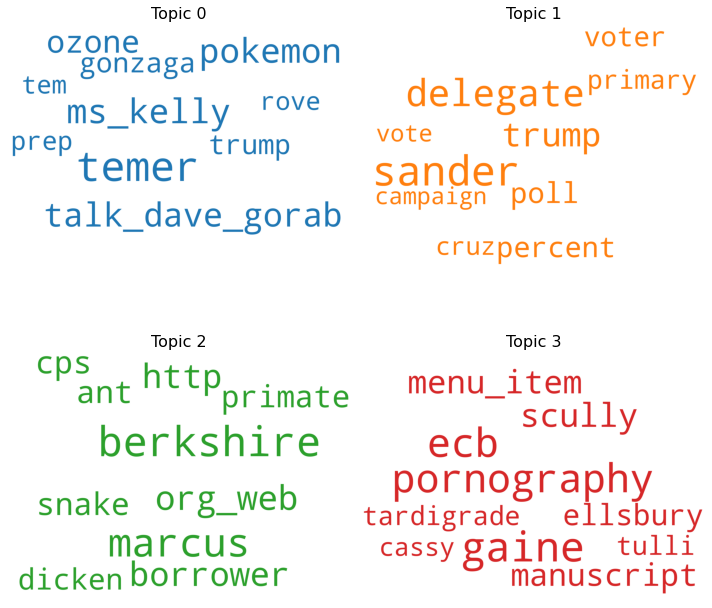

In [34]:
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

lda_model = lda_model_tfidf

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

In [35]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=data_ready, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.791679671825639

Coherence Score:  0.6115041362140273


/home/fefy/.local/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


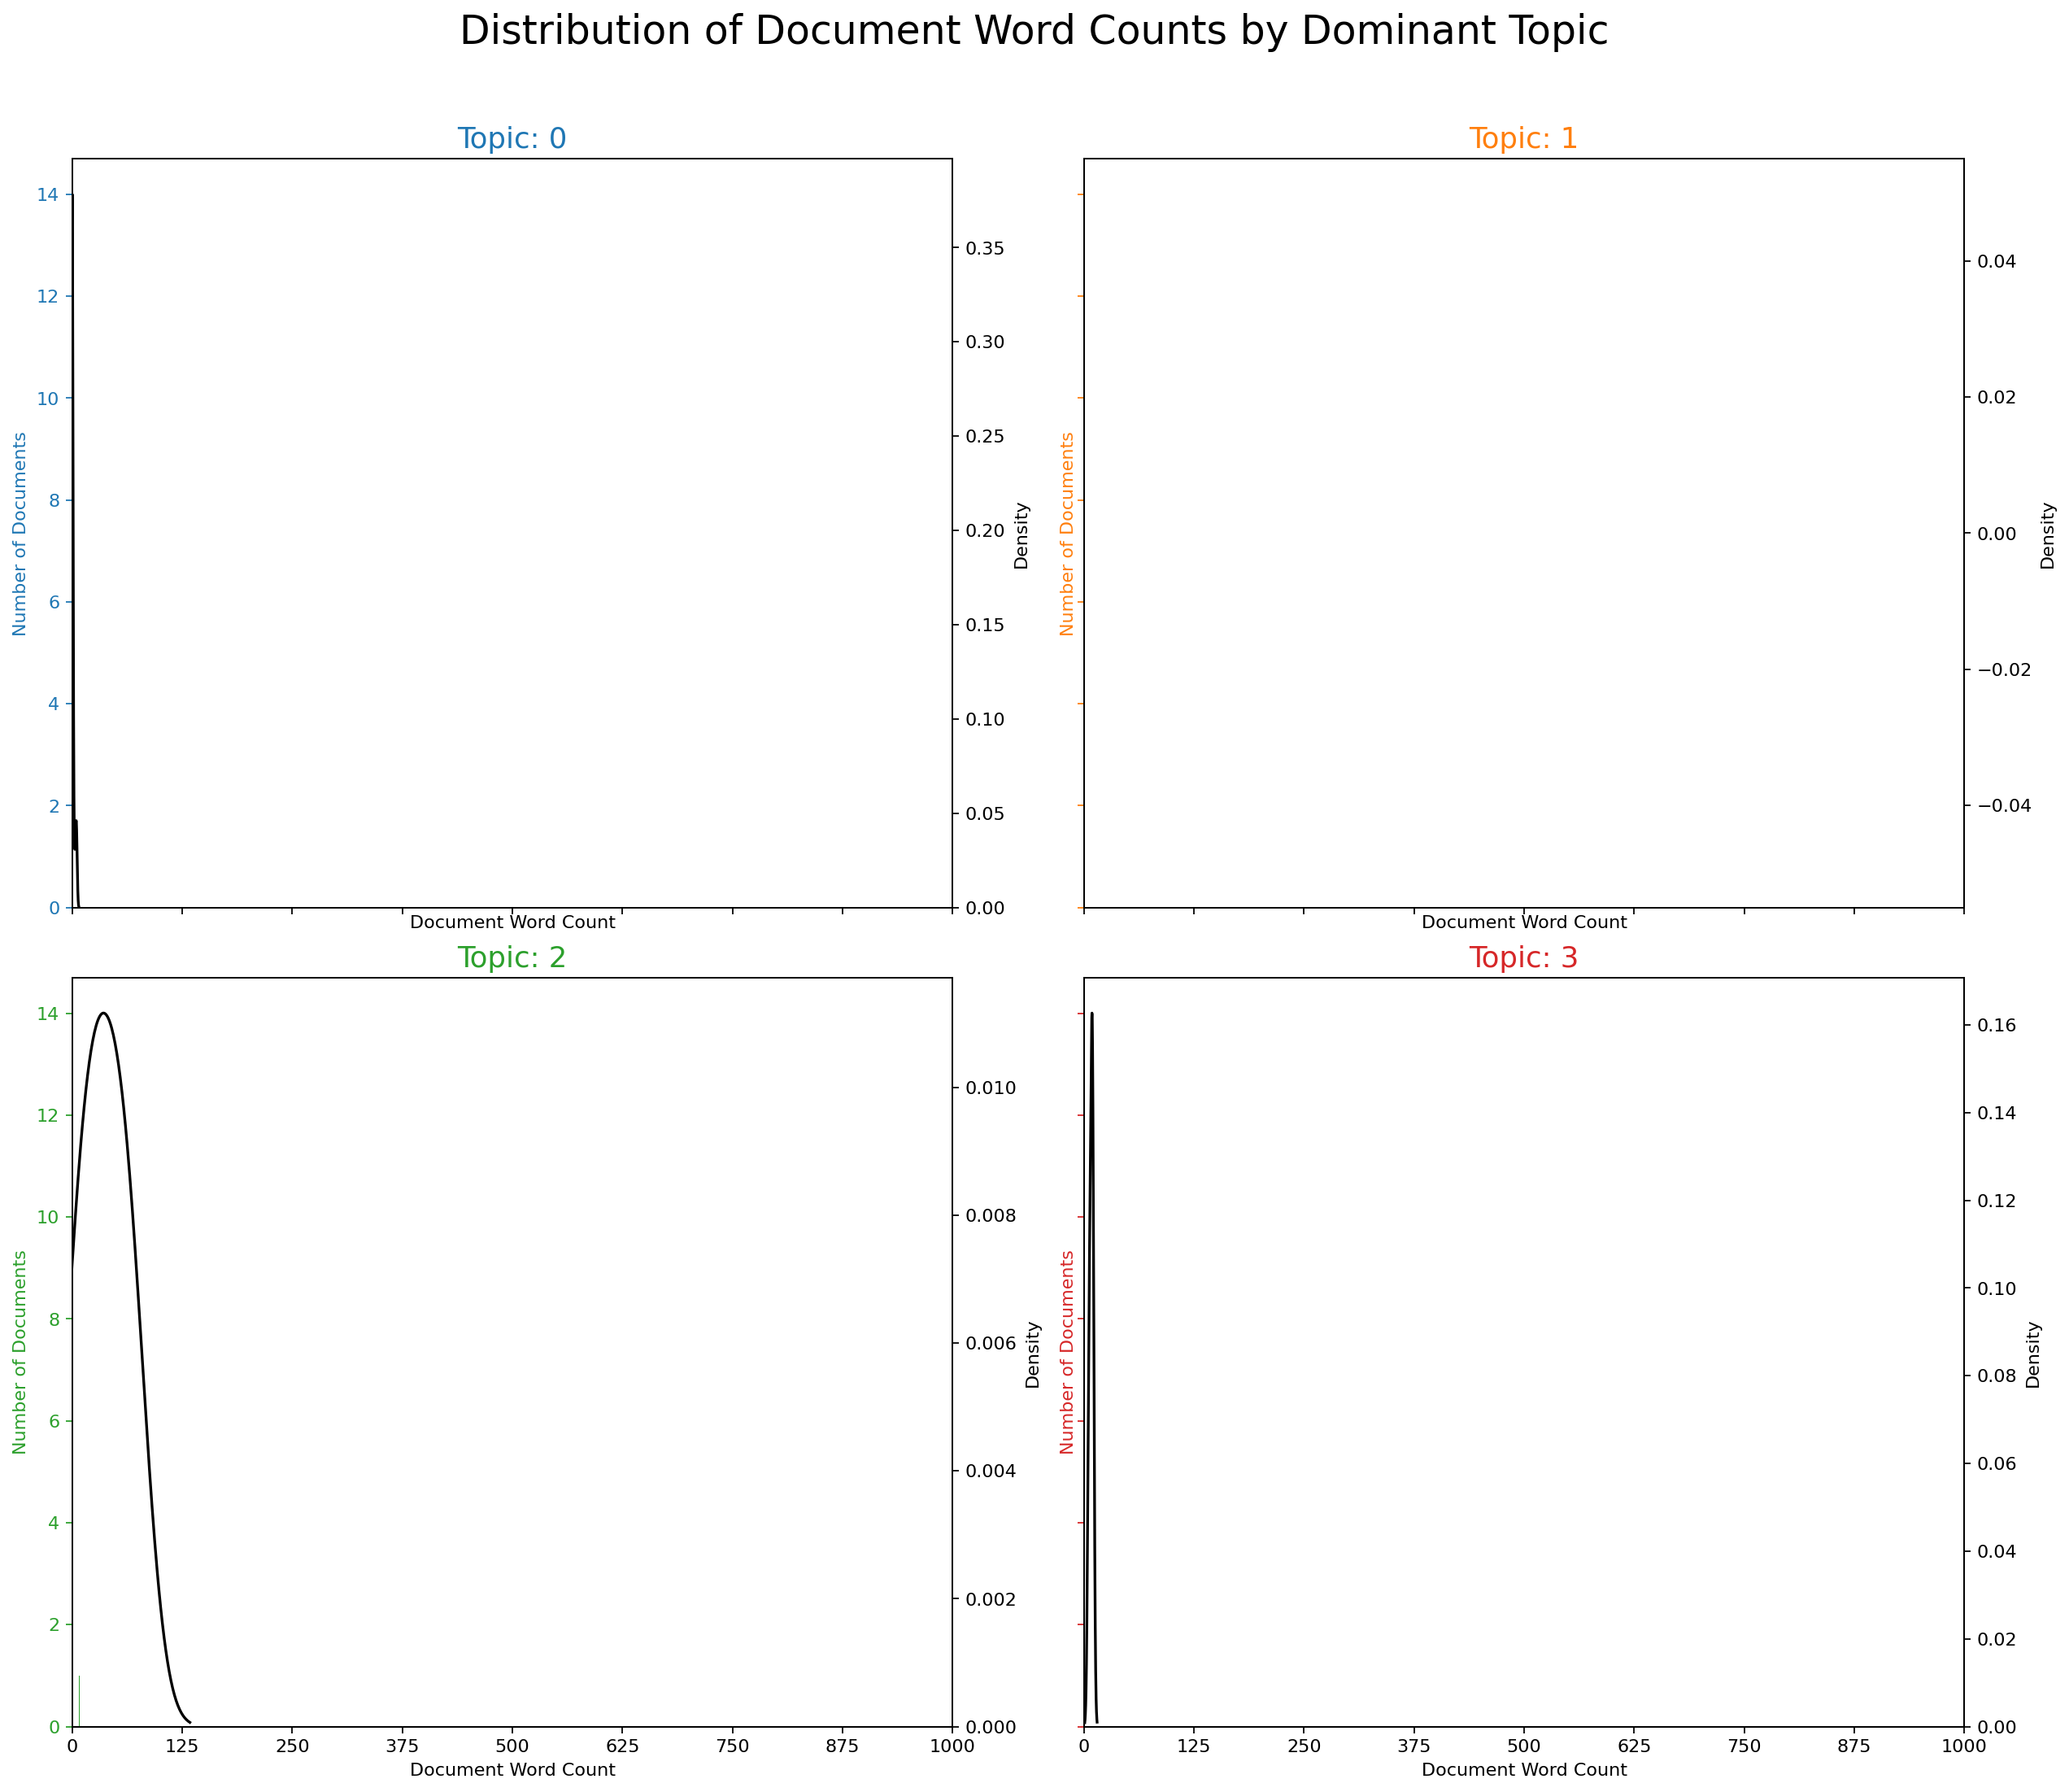

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()